In [151]:
!pip install imbalanced-learn

     |████████████████████████████████| 206 kB 36.5 MB/s eta 0:00:01
You should consider upgrading via the '/home/ubuntu/pyenv/bin/python -m pip install --upgrade pip' command.


In [2]:
import sys
from pprint import pprint
from pymongo import MongoClient 
import torch
import json
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import imblearn

## Database Handling

In [3]:
df = pd.read_pickle("raw_df.pkl")

In [4]:
df.head()

,ip,_id.$oid,data.src_port,data.message,data.timestamp,data.sensor_geo.$binary.base64,data.sensor_geo.$binary.subType,data.sensor_segment.$binary.base64,data.sensor_segment.$binary.subType,data.ip_country,...,data.keyAlgs,data.encCS,data.macCS,data.compCS,data.langCS,data.username,data.password,data.version,data.arch,data.input
0,139.59.39.39,6108eec5d26b021841493be7,22.0,hex,1.627975e+09,REU=,00,Rkk=,00,IN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,206.189.48.208,6108eec5d26b021841493be6,NaN,Closing TTY Log: var/lib/cowrie/tty/28720365c5...,1.627975e+09,REU=,00,Rkk=,00,DE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36.92.74.150,6108eec5d26b021841493be5,NaN,SSH client hassh fingerprint: 98ddc5604ef6a100...,1.627975e+09,U0c=,00,R08=,00,ID,...,"[ssh-rsa-cert-v01@openssh.com, ssh-dss-cert-v0...","[aes128-gcm@openssh.com, chacha20-poly1305@ope...","[hmac-sha2-256-etm@openssh.com, hmac-sha2-256,...",[none],[],NaN,NaN,NaN,NaN,NaN
3,79.106.48.178,6108eec59cc40ececbf48afc,NaN,login attempt [root/19810927] succeeded,1.627975e+09,REU=,00,Rkk=,00,AL,...,NaN,NaN,NaN,NaN,NaN,root,19810927,NaN,NaN,NaN
4,154.221.20.149,6108eec58f7501d3ef4899c9,NaN,Connection lost after 2 seconds,1.627975e+09,VVM=,00,VEU=,00,HK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocessing

In [5]:
def factorize_df(df, categorial_col):
    """ Transofrms non-numeric values into dummy values """

    new_df = pd.DataFrame(columns=df.columns)
    for col in categorial_col:
        new_df[col], _ = df[col].factorize()
    not_categorial_cols = [col for col in df.columns if col not in categorial_col]
    for col in not_categorial_cols:
        new_df[col] = df[col]
    return new_df

In [6]:
def aggregate_session_data(df):
    """ Aggregates the raw data into a sample per session """

    unique_session_ids = df["data.session"].unique()
    print(f'number of unique session ids: {len(unique_session_ids)}')
    
    # types of sessions events
    event_types = ['log.closed', 'client.kex', 'login.success', 'session.closed', 'client.version', 'session.params', 
                   'command.input', 'session.file_download', 'session.file_download.failed', 'command.failed', 
                   'session.file_upload', 'client.var', 'command.success']
    cols = list(df.columns) + event_types # transforming the columns
    cols.remove("data.eventid")
    cols.remove("data.session")

    sessions_df = pd.DataFrame(columns=cols)

    # columns which all values are unique for all session events
    identical_cols = ["data.session", "ip", "data.ip_country", "data.sensor", "data.src_ip", "data.sen_dist", 
                      "data.src_language", "data.src_os_name", "data.src_uptime_sec", "data.sensor_geo.$binary.base64", 
                      "data.sensor_segment.$binary.base64", "data.bf"]
    
    # DataFrame creation
    for i, session_id in enumerate(unique_session_ids):
        # logging
        if i % 10000 == 0:
            print(f'{i}. Session ID {session_id}')
            sessions_df.to_pickle(f"processed_data_{i}.pkl")

        session_events = df[df["data.session"]==session_id]
        first_session = session_events.iloc[0]
        session = {col: first_session[col] for col in identical_cols}
        session.update({col: 0 for col in event_types})
        event_id_fields = session_events["data.eventid"].value_counts().to_dict()
        session.update(event_id_fields)
        session["data.message"] = session_events["data.message"].to_string()
        sessions_df = sessions_df.append(session, ignore_index=True)
    
    sessions_df.loc["data.bf"] = sessions_df["data.bf"].astype(int)

    # saving the processed data
    sessions_df.to_pickle("processed_data.pkl")
    print("pickled processed_data")

    return sessions_df

In [7]:
def add_label_column(df): 
    """ Adding the label - 0 if ip doesn't return in the data, else 1. """

    df["label"] = 0
    unique_ips = df["ip"].unique()
    print("number of unique ips:", len(unique_ips))

    # label creation
    for i, ip in enumerate(unique_ips):
        # logging
        if i % 500 == 0:
            print(f'{i}. IP {ip}')

        sessions = df[df["ip"]==ip]["data.session"].unique() # all sessions with the same IP
        if len(sessions) != 1: # IP is repeated in different sessions
            df.loc[df.ip == ip, "label"] = 1

    del df["data.session"] # sessions id isn't meaningful anymore

In [19]:
def preprocess(df):
    """ Preprocess the data - end to end """

    # removing rows without session id
    df = df[df["data.session"].notna()]

    # removing columns which aren't meaningful
    cols_to_remove_new = ['_id.$oid', 'data.src_port', 'data.timestamp', 'data.weather', 'data.port', 'data.size', 
                          'data.shasum', 'data.ttylog', 'data.duplicate', 'data.duration', 'data.sen_os', 'data.sen_ver', 
                          'data.src_os_flavor', 'data.hassh', 'data.hasshAlgorithms', 'data.kexAlgs', 'data.keyAlgs', 
                          'data.encCS', 'data.macCS', 'data.compCS', 'data.langCS', 'data.username', 'data.password', 
                          'data.version', 'data.arch', 'data.input', 'data.sensor_geo.$binary.subType', 
                          'data.sensor_segment.$binary.subType']
    for col in cols_to_remove_new:
      del df[col]

    # timing has no meaning, therefore using hot-encoding
    df.loc[df["data.src_uptime_sec"].notna(), "data.src_uptime_sec"] = 1
    df.loc[df["data.src_uptime_sec"].isna(), "data.src_uptime_sec"] = 0

    # sessions aggergation
    sessions_df = aggregate_session_data(df)

    # labeling
    print("starting add label")
    add_label_column(sessions_df)
    print("finished add label")

    # transofrming into numeric data
    categorical_cols = ["ip", "data.sensor_geo.$binary.base64", "data.sensor_segment.$binary.base64", 
                        "data.ip_country", "data.message", "data.sensor", "data.src_ip", "data.sen_dist", 
                        "data.src_language", "data.src_os_name"]
    processed_data = factorize_df(sessions_df, categorical_cols)
        
    # saving the preprocessed data
    processed_data.to_pickle("factorized_data.pkl")
    print("pickled factorized_data")

    return processed_data

In [20]:
def prepare_data_for_model(df):
    # remove ip columns and NaN columns
    for col in ["client.size", "client.fingerprint", "ip", "data.src_ip"]:
        if col in df.columns:
            del df[col]

In [21]:
def get_train_test_data(data):
    """ Processing the data and splitting into test & train sets differentiated by IPs """

    # data preprocessing
    processed_data = preprocess(data)
    print(processed_data["label"].value_counts())

    # getting all unique ideas to create the data sets
    unique_ips = processed_data.drop_duplicates(subset=["ip"])
    X = unique_ips.loc[:, processed_data.columns != "label"]
    y = unique_ips["label"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    train_ips = X_train["ip"].unique()
    test_ips = X_test["ip"].unique()

    train = processed_data[processed_data["ip"].isin(train_ips)] # all rows that has the train ips
    test = processed_data[processed_data["ip"].isin(test_ips)] # all rows that has the test ips

    X_train = train.loc[:, processed_data.columns != "label"]
    y_train = train["label"]

    X_test = test.loc[:, processed_data.columns != "label"]
    y_test = test["label"]
    
    prepare_data_for_model(X_train)
    prepare_data_for_model(X_test)
    
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = get_train_test_data(df)

/home/ubuntu/pyenv/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


number of unique session ids: 315497
0. Session ID 6bb9d8312f0f


KeyboardInterrupt: 

In [202]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_test.to_pickle('y_test.pkl')

In [11]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(162751, 67249, 162751, 67249)

command.failed


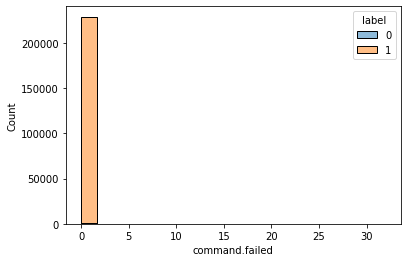

data.src_language


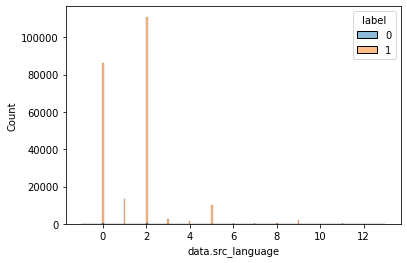

data.ip_country


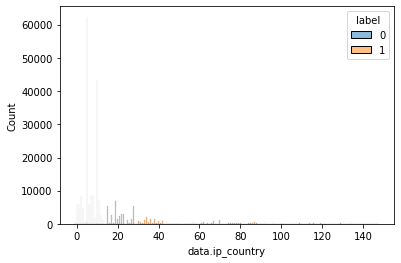

data.message


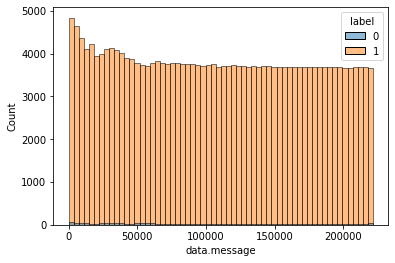

In [243]:
columns = ["data.bf", 'data.sensor_geo.$binary.base64',
           'data.sensor_segment.$binary.base64', 'log.closed',
       'client.kex', 'login.success', 'session.closed', 'client.version',
       'session.params', 'command.input', 'session.file_download',
       'session.file_download.failed', 'command.failed', 'session.file_upload',
       'client.var', 'command.success', 'client.size', 'data.src_uptime_sec']
for col in columns:
    print(col)
    sns.histplot(data=X_train, x=col, hue="label")
    plt.show()

## Model Selection

In [13]:
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [25]:
train_X = X_train.values
test_X = X_test.values
train_y = y_train.values.astype(int)
test_y = y_test.values.astype(int)

In [26]:
models = [
    SVC(random_state=1),
    MLPClassifier(random_state=1),
    RandomForestClassifier(random_state=1),
    BalancedBaggingClassifier(),
    RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', random_state=1),
    BalancedRandomForestClassifier()
]

model_names = ["SVC", "MLP", "Random\nForest", "Balanced\nBagging", "Random\nForest\nv2", "Balanced\nRandom\nForest"]
precisions = []
recalls = []
fprs = []


for model in models:
    print(model)
    model.fit(train_X, train_y)
    test_preds = model.predict(test_X).round()
    precision = precision_score(test_y, test_preds)
    recall = recall_score(test_y, test_preds)
    precisions.append(precision)
    recalls.append(recall)

    print("precision_score on test:", precision)
    print("recall_score on test:", recall)

    fps = ((test_y != test_preds) & (test_preds == 1)).sum()
    total_negatives = (test_y == 0).sum()
    fpr = fps/total_negatives
    print("num fps:", fps, "fpr:", fpr, "\n")
    fprs.append(fpr)

SVC(random_state=1)
precision_score on test: 0.9934571517792086
recall_score on test: 1.0
num fps: 440 fpr: 1.0 

MLPClassifier(random_state=1)
precision_score on test: 0.9934571517792086
recall_score on test: 1.0
num fps: 440 fpr: 1.0 

RandomForestClassifier(random_state=1)
precision_score on test: 0.995305725818508
recall_score on test: 0.9965124459279439
num fps: 314 fpr: 0.7136363636363636 

BalancedBaggingClassifier()
precision_score on test: 0.998294691774609
recall_score on test: 0.8236614827343621
num fps: 94 fpr: 0.21363636363636362 

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=10,
                       random_state=1)
precision_score on test: 0.9954195045281042
recall_score on test: 0.9953599065994102
num fps: 306 fpr: 0.6954545454545454 

BalancedRandomForestClassifier()
precision_score on test: 0.9985642498205313
recall_score on test: 0.791180828930234
num fps: 76 fpr: 0.17272727272727273 



### Precisions Plot

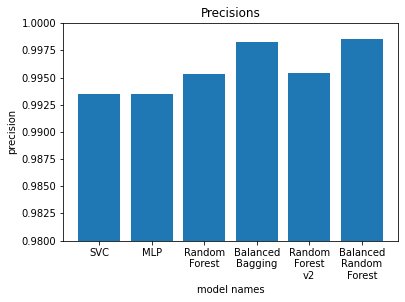

In [37]:
plt.bar(model_names, precisions)
plt.ylim(0.98, 1)
plt.title('Precisions')
plt.xlabel('model names')
plt.ylabel('precision')
plt.show()

### Recalls Plot

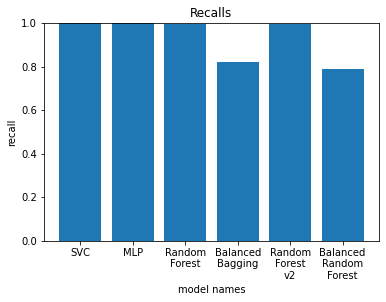

In [41]:
plt.bar(model_names, recalls)
plt.ylim(0, 1)
plt.title('Recalls')
plt.xlabel('model names')
plt.ylabel('recall')
plt.show()

### FPRs Plot

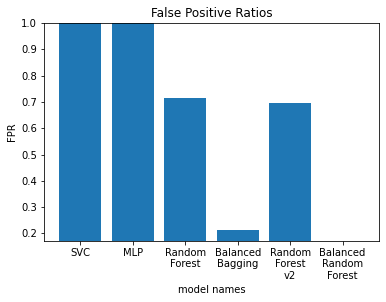

In [29]:
plt.bar(model_names, fprs)
plt.ylim(min(fprs), max(fprs))
plt.title('False Positive Ratios')
plt.xlabel('model names')
plt.ylabel('FPR')
plt.show()

### TODO - Model Selection

1. Run models with different random seeds
2. Hyperparameters tuning